In [136]:
import pandas as pd
import numpy as np
from sklearn.metrics import r2_score
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV
import os
from sklearn.tree import DecisionTreeRegressor, plot_tree
import matplotlib.pyplot as plt
import seaborn as sns

In [137]:
import os
os.chdir("C:\\Users\\DELL\\Downloads")
tx=pd.read_csv("uber.csv")

In [138]:
# always create a copy
txcp=tx.copy()

In [139]:
txcp.shape

(200000, 9)

In [140]:
txcp.isnull().sum()

Unnamed: 0           0
key                  0
fare_amount          0
pickup_datetime      0
pickup_longitude     0
pickup_latitude      0
dropoff_longitude    1
dropoff_latitude     1
passenger_count      0
dtype: int64

In [141]:
#fill the null values with mean value
txcp['dropoff_longitude']=txcp['dropoff_longitude'].fillna(txcp['dropoff_longitude'].mean())
txcp['dropoff_latitude']=txcp['dropoff_latitude'].fillna(txcp['dropoff_latitude'].mean())



In [142]:
txcp.isnull().sum()
# no null values in the dataset

Unnamed: 0           0
key                  0
fare_amount          0
pickup_datetime      0
pickup_longitude     0
pickup_latitude      0
dropoff_longitude    0
dropoff_latitude     0
passenger_count      0
dtype: int64

In [143]:
txcp.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200000 entries, 0 to 199999
Data columns (total 9 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   Unnamed: 0         200000 non-null  int64  
 1   key                200000 non-null  object 
 2   fare_amount        200000 non-null  float64
 3   pickup_datetime    200000 non-null  object 
 4   pickup_longitude   200000 non-null  float64
 5   pickup_latitude    200000 non-null  float64
 6   dropoff_longitude  200000 non-null  float64
 7   dropoff_latitude   200000 non-null  float64
 8   passenger_count    200000 non-null  int64  
dtypes: float64(5), int64(2), object(2)
memory usage: 13.7+ MB


In [144]:
txcp.dtypes

Unnamed: 0             int64
key                   object
fare_amount          float64
pickup_datetime       object
pickup_longitude     float64
pickup_latitude      float64
dropoff_longitude    float64
dropoff_latitude     float64
passenger_count        int64
dtype: object

In [145]:
txcp=txcp.drop(["Unnamed: 0","key"],axis=1)

In [146]:
txcp.dtypes

fare_amount          float64
pickup_datetime       object
pickup_longitude     float64
pickup_latitude      float64
dropoff_longitude    float64
dropoff_latitude     float64
passenger_count        int64
dtype: object

In [147]:
txcp.pickup_datetime = pd.to_datetime(txcp.pickup_datetime)
txcp.dtypes

fare_amount                      float64
pickup_datetime      datetime64[ns, UTC]
pickup_longitude                 float64
pickup_latitude                  float64
dropoff_longitude                float64
dropoff_latitude                 float64
passenger_count                    int64
dtype: object

In [148]:
# feature extraction

txcp = txcp.assign(hour = txcp.pickup_datetime.dt.hour,
               day = txcp.pickup_datetime.dt.day,
               month = txcp.pickup_datetime.dt.month,
               year = txcp.pickup_datetime.dt.year,
               dayofweek = txcp.pickup_datetime.dt.dayofweek)

In [149]:
txcp.shape

(200000, 12)

In [150]:
#finding negative values
nvl=txcp["fare_amount"]>0
nvl.value_counts()

True     199978
False        22
Name: fare_amount, dtype: int64

In [151]:
txcp=txcp[txcp["fare_amount"]>0]

In [152]:
txcp.describe()

,fare_amount,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,hour,day,month,year,dayofweek
count,199978.000000,199978.000000,199978.000000,199978.000000,199978.000000,199978.000000,199978.000000,199978.000000,199978.000000,199978.000000,199978.00000
mean,11.362649,-72.527851,39.935999,-72.526243,39.924410,1.684480,13.491399,15.705003,6.282146,2011.742307,3.04845
std,9.897079,11.437257,7.720443,13.115081,6.793421,1.385974,6.515409,8.687539,3.438924,1.856277,1.94697
min,0.010000,-1340.648410,-74.015515,-3356.666300,-881.985513,0.000000,0.000000,1.000000,1.000000,2009.000000,0.00000
25%,6.000000,-73.992065,40.734795,-73.991407,40.733824,1.000000,9.000000,8.000000,3.000000,2010.000000,1.00000
50%,8.500000,-73.981823,40.752592,-73.980093,40.753042,1.000000,14.000000,16.000000,6.000000,2012.000000,3.00000
75%,12.500000,-73.967155,40.767158,-73.963659,40.768001,2.000000,19.000000,23.000000,9.000000,2013.000000,5.00000
max,499.000000,57.418457,1644.421482,1153.572603,872.697628,208.000000,23.000000,31.000000,12.000000,2015.000000,6.00000


In [153]:
# function to calculate the travel distance from the longitudes and latitudes
from math import *
    
def distance(longitude1, latitude1, longitude2, latitude2):
    travel_dist = []
    
    for pos in range (len(longitude1)):
        long1, lat1, long2, lat2 = map(radians, [longitude1[pos], latitude1[pos],
                                               longitude2[pos], latitude2[pos]])
        dist_long = long2 - long1
        dist_lat = lat2 - lat1
        
        a = sin(dist_lat/2)**2 + cos(lat1) * cos(lat2) * sin(dist_long/2)**2
        
        #radius of earth = 6371
        c = 2 * asin(sqrt(a)) * 6371 
        travel_dist.append(c)
            
    return  travel_dist

In [154]:
txcp['dist_travelled'] = distance(txcp.pickup_longitude.to_numpy(), txcp.pickup_latitude.to_numpy(),
                                  txcp.dropoff_longitude.to_numpy(), txcp.dropoff_latitude.to_numpy())


In [155]:
txcp.shape

(199978, 13)

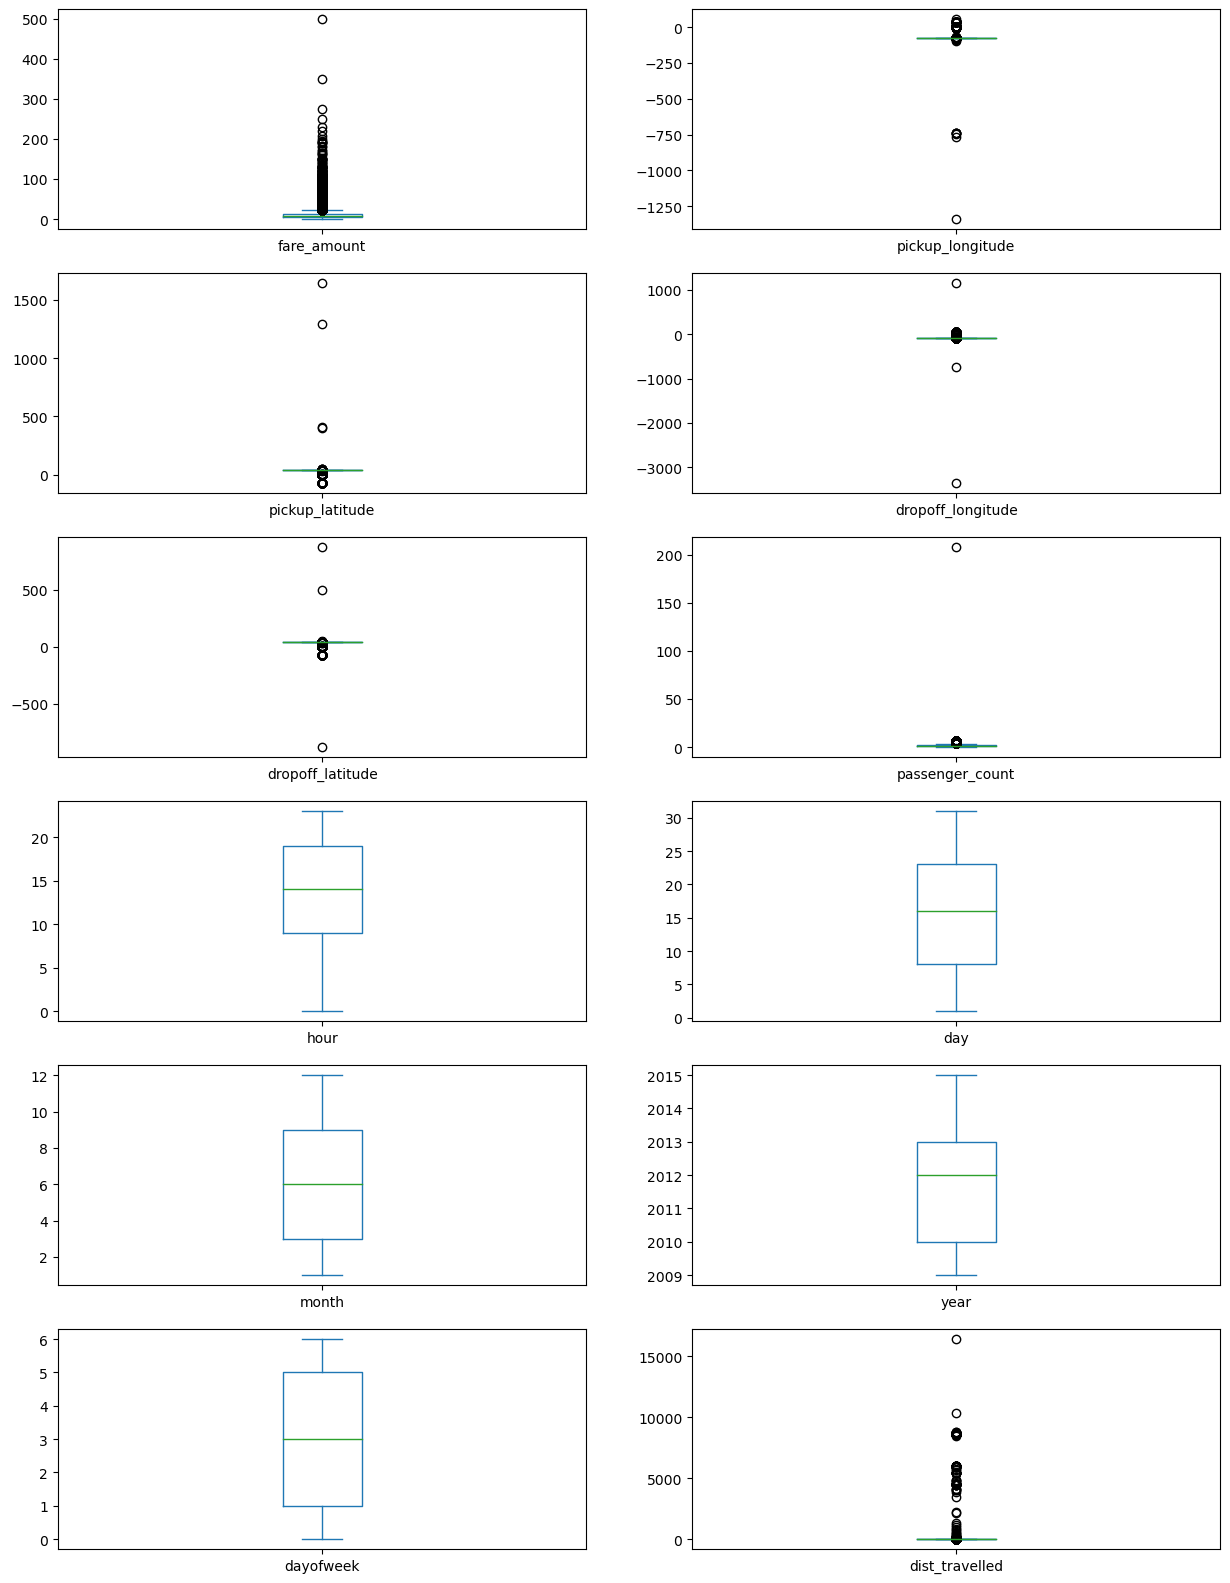

In [156]:
import matplotlib.pyplot as plt
txcp.plot(kind = "box",subplots = True,layout = (6,2),figsize=(15,20)) #Boxplot to check the outliers
plt.show()

In [244]:
#Using the InterQuartile Range to fill the values
def remove_outlier(df1 , col):
    Q1 = df1[col].quantile(0.25)
    Q3 = df1[col].quantile(0.75)
    IQR = Q3 - Q1
    lower_whisker = Q1-1.5*IQR
    upper_whisker = Q3+1.5*IQR
    txcp[col] = np.clip(df1[col] , lower_whisker , upper_whisker)
    return df1

def treat_outliers_all(df1 , col_list):
    for c in col_list:
        df1 = remove_outlier(txcp , c)
    return df1

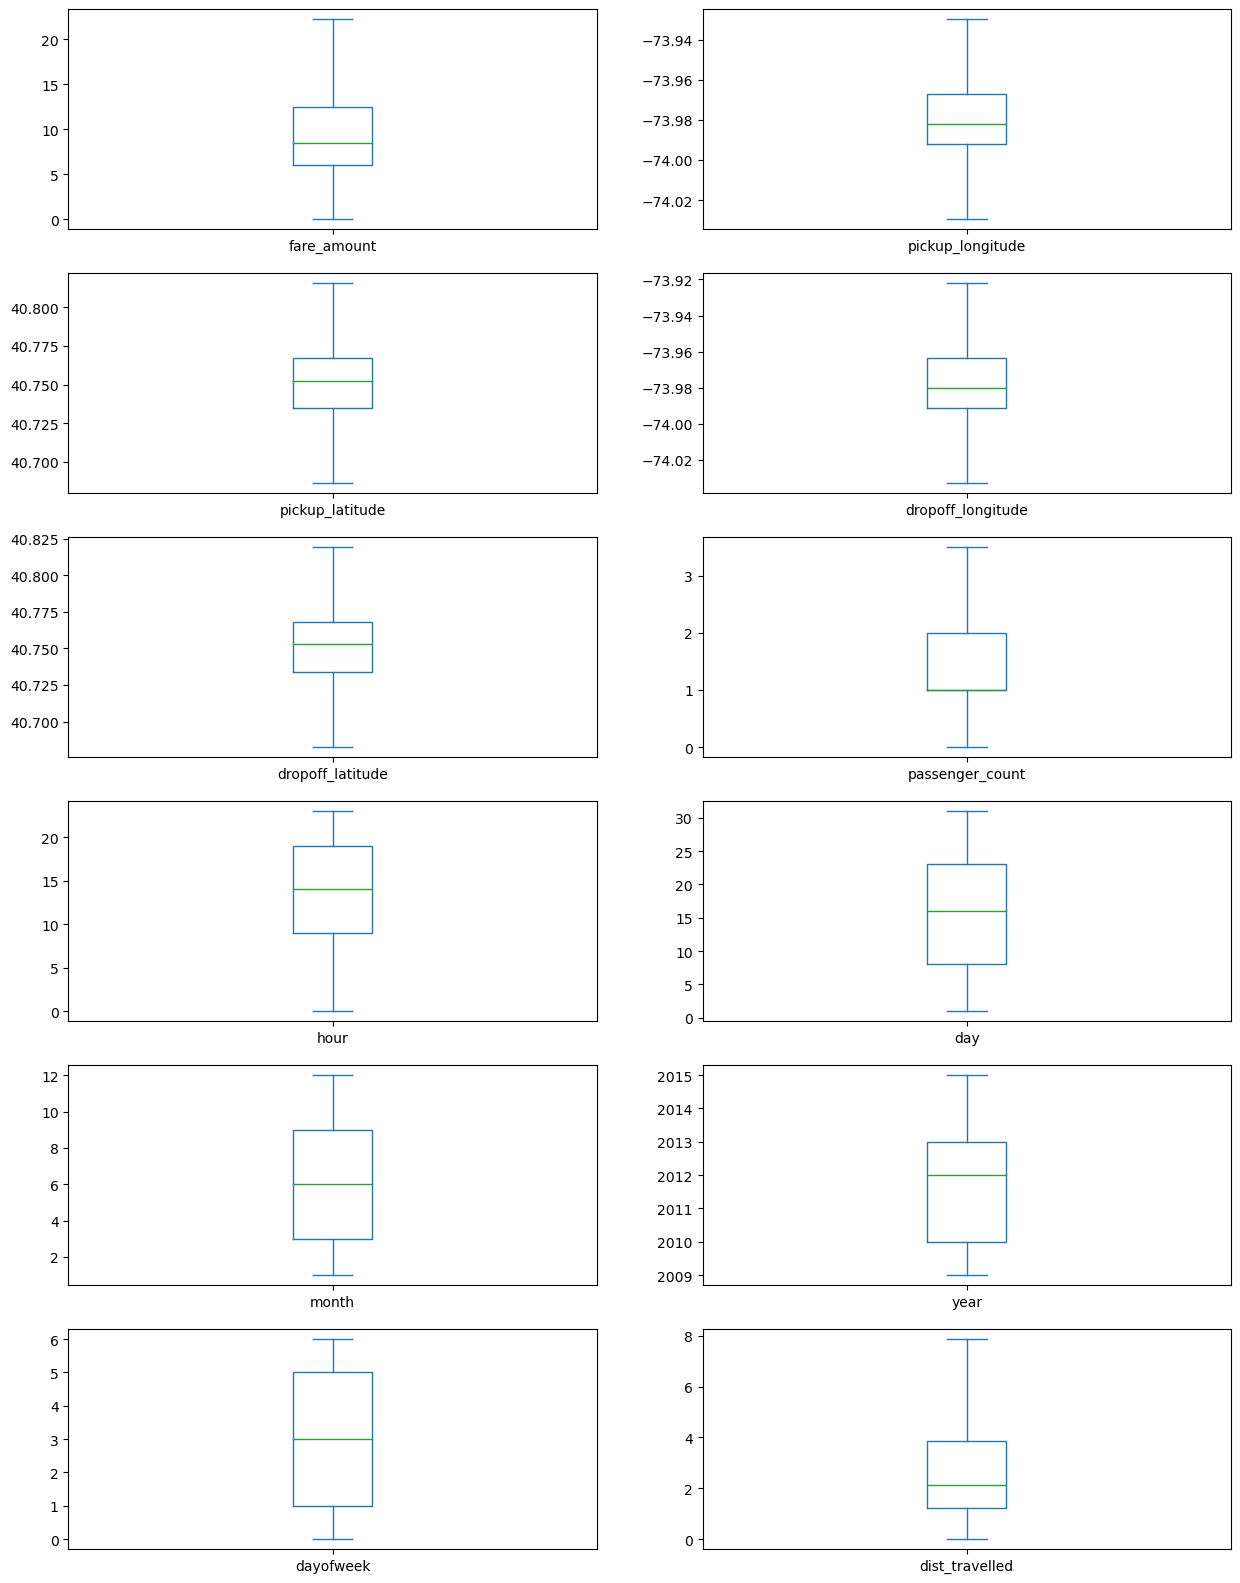

In [245]:
txcp=treat_outliers_all(txcp,txcp.iloc[:,::])
import matplotlib.pyplot as plt
txcp.plot(kind = "box",subplots = True,layout = (6,2),figsize=(15,20)) #Boxplot to check the outliers
plt.show()

In [159]:
#txcp.to_csv("C:\\Users\\Dell\\Desktop\\project\\newuberf2.csv",index=False)

                                       Correlation Matrix                                       


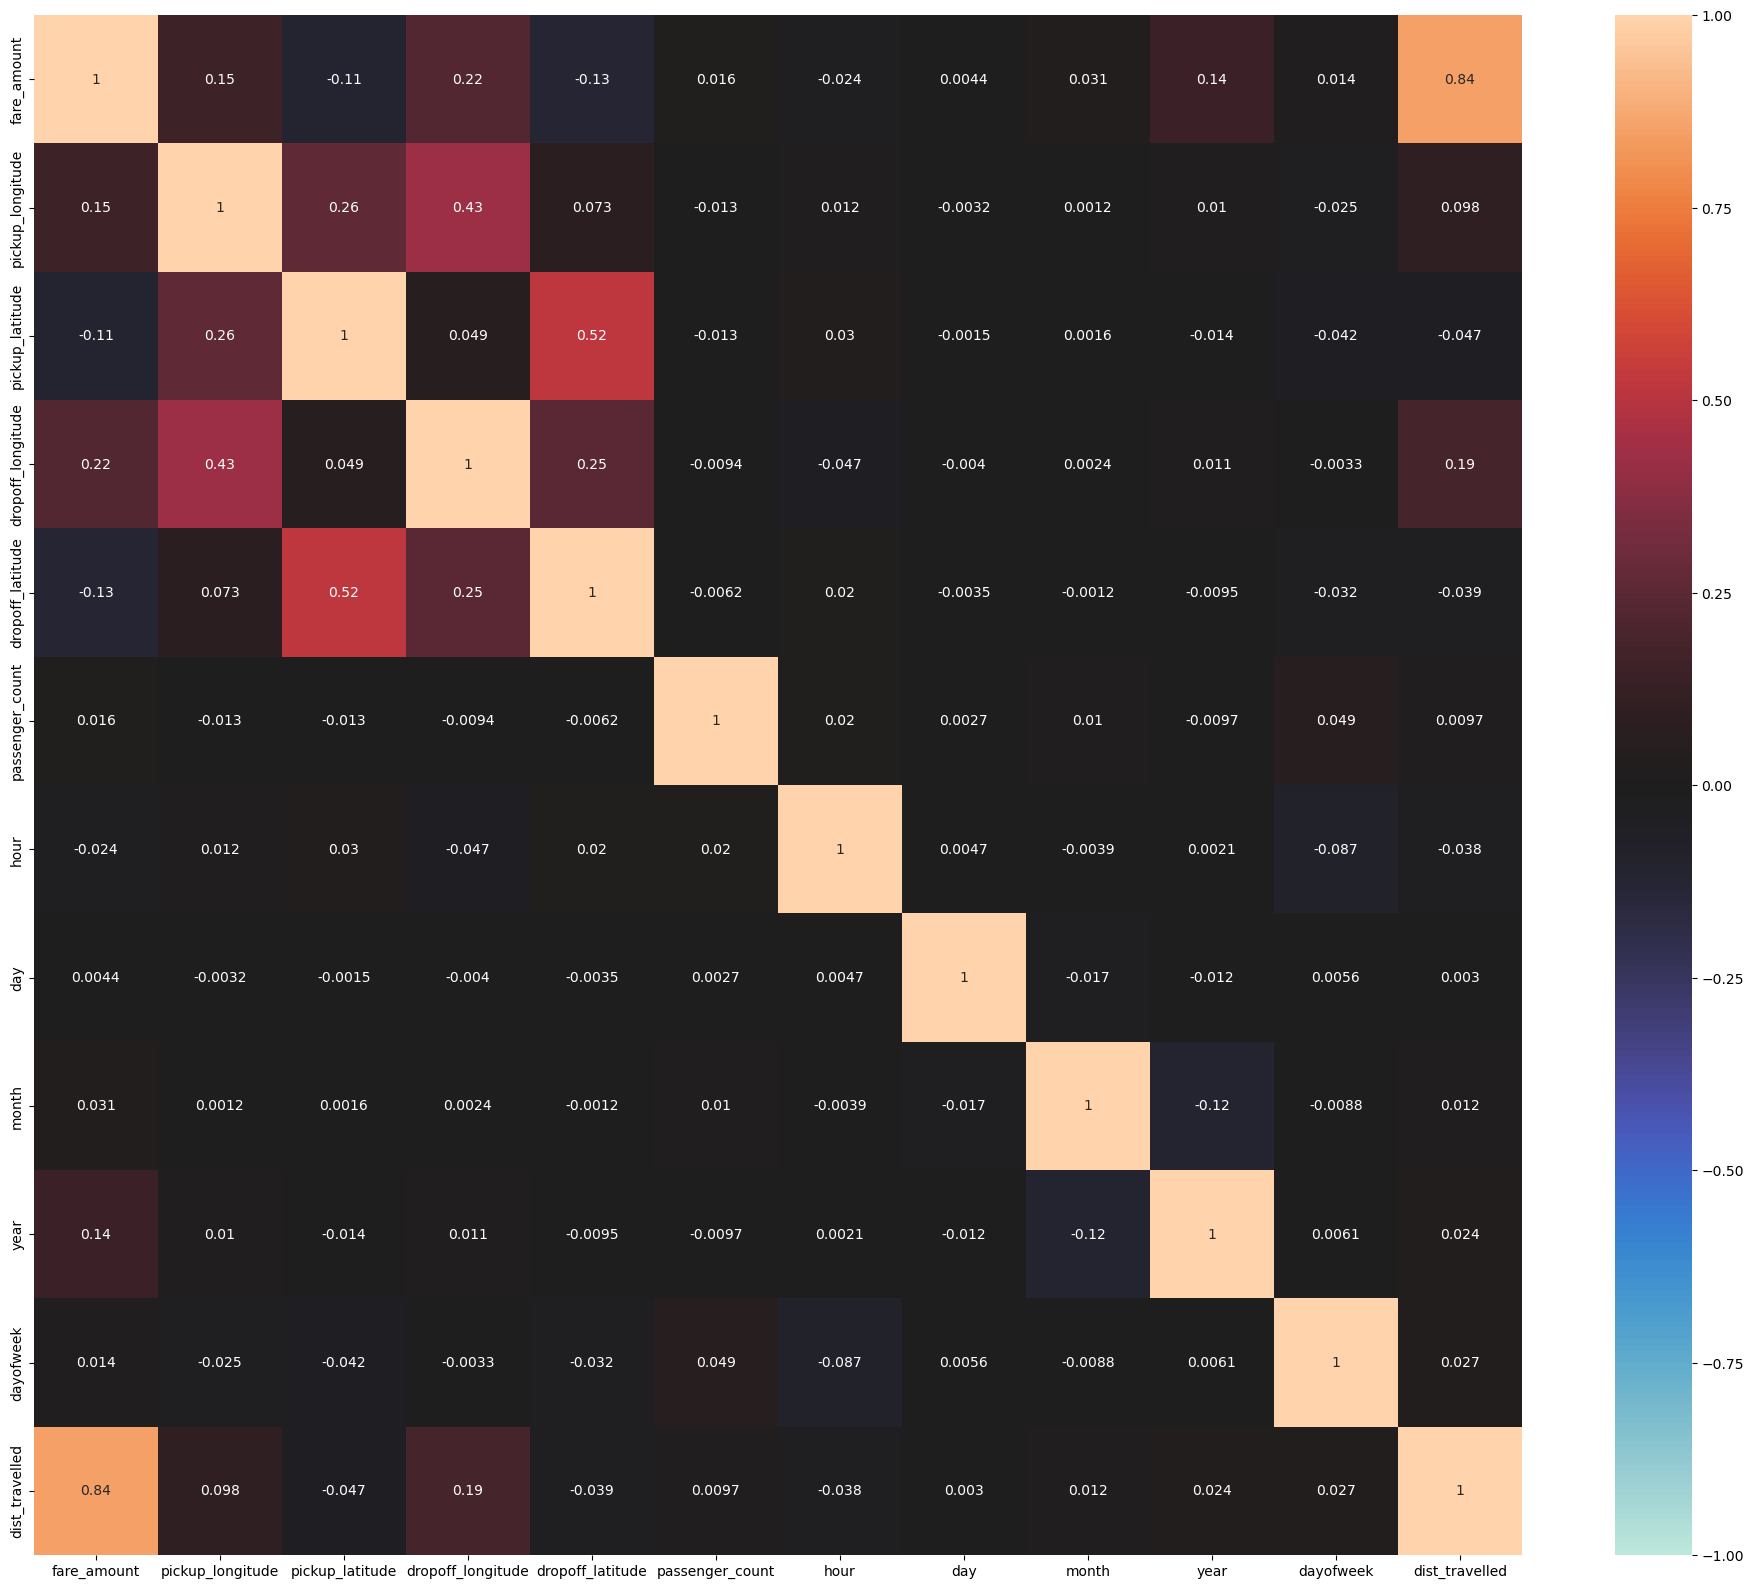

In [246]:
# DATA CORRELATION USING HEATMAP

print('\033[1mCorrelation Matrix'.center(100))
plt.figure(figsize=[24,20])
sns.heatmap(txcp.corr(), annot=True, vmin=-1, vmax=1, center=0)
plt.show()

In [247]:
txcp.drop('pickup_datetime',axis=1)

,fare_amount,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,hour,day,month,year,dayofweek,dist_travelled
0,7.50,-73.999817,40.738354,-73.999512,40.723217,1.0,19,7,5,2015,3,1.683323
1,7.70,-73.994355,40.728225,-73.994710,40.750325,1.0,20,17,7,2009,4,2.457590
2,12.90,-74.005043,40.740770,-73.962565,40.772647,1.0,21,24,8,2009,0,5.036377
3,5.30,-73.976124,40.790844,-73.965316,40.803349,3.0,8,26,6,2009,4,1.661683
4,16.00,-73.929790,40.744085,-73.973082,40.761247,3.5,17,28,8,2014,3,4.475450
...,...,...,...,...,...,...,...,...,...,...,...,...
199995,3.00,-73.987042,40.739367,-73.986525,40.740297,1.0,10,28,10,2012,6,0.112210
199996,7.50,-73.984722,40.736837,-74.006672,40.739620,1.0,1,14,3,2014,4,1.875050
199997,22.25,-73.986017,40.756487,-73.922037,40.692588,2.0,0,29,6,2009,0,7.865233
199998,14.50,-73.997124,40.725452,-73.983215,40.695415,1.0,14,20,5,2015,2,3.539715


# Feature Scaling (Standardization)

In [248]:

from sklearn.preprocessing import StandardScaler

In [249]:
x = txcp.drop(['fare_amount','pickup_datetime'], axis = 1)
y = txcp['fare_amount']

In [250]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.7, random_state = 2023)

In [251]:
x_train.shape

(59993, 11)

In [252]:
y_train.shape

(59993,)

In [253]:
x_test.shape

(139985, 11)

In [254]:
y_test.shape

(139985,)

# Regression Models

Linear Regression

In [255]:
from sklearn.linear_model import LinearRegression
LR = LinearRegression()
LR.fit(x_train,y_train)

LinearRegression()

In [177]:
LR_pred = LR.predict(x_test)

In [179]:
from sklearn import metrics
from sklearn.metrics import r2_score

MAE_LR= metrics.mean_absolute_error(y_test, LR_pred)
MSE_LR= metrics.mean_squared_error(y_test, LR_pred)
RMSE_LR= np.sqrt(metrics.mean_squared_error(y_test, LR_pred))
r2_LR=r2_score(y_test, LR_pred)

In [180]:
print('Mean absolute error of linear regression',MAE_LR)
print('Mean square  error of linear regression',MSE_LR)
print('root Mean square error of linear regression',RMSE_LR)
print('r2 score of linear regression',r2_LR)

Mean absolute error of linear regression 1.8049151170324391
Mean square  error of linear regression 7.439416644842757
root Mean square error of linear regression 2.7275294031124133
r2 score of linear regression 0.7482082223158605


In [240]:
from sklearn.linear_model import Lasso

In [241]:

lasso = Lasso(alpha=2.5)
lasso.fit(x_train, y_train)
lasso_pred = lasso.predict(x_test)


In [242]:
from sklearn import metrics
from sklearn.metrics import r2_score

MAE_lasso= metrics.mean_absolute_error(y_test, lasso_pred)
MSE_lasso= metrics.mean_squared_error(y_test, lasso_pred)
RMSE_lasso= np.sqrt(metrics.mean_squared_error(y_test, lasso_pred))
r2_lasso=r2_score(y_test, lasso_pred)


In [243]:
print('Mean absolute error of lasso regression',MAE_lasso)
print('Mean square  error of lasso regression',MSE_lasso)
print('root Mean square error of lasso regression',RMSE_lasso)
print('r2 score of lasso regression',r2_lasso)

Mean absolute error of lasso regression 2.345052345580413
Mean square  error of lasso regression 9.756232582449687
root Mean square error of lasso regression 3.12349685167917
r2 score of lasso regression 0.6691622044022503


Elastic Regression

In [185]:
from sklearn.linear_model import ElasticNet

In [186]:
x = txcp.drop(['fare_amount','pickup_datetime'], axis=1)
y = txcp['fare_amount']

x_train, x_test, y_train, y_test = train_test_split(x, y,
                                                    random_state=2022,
                                                    train_size=0.7)
elastic = ElasticNet()
elastic.fit(x_train, y_train)
elastic_pred = elastic.predict(x_test)

In [187]:
from sklearn import metrics
from sklearn.metrics import r2_score

MAE_elastic= metrics.mean_absolute_error(y_test, elastic_pred)
MSE_elastic= metrics.mean_squared_error(y_test, elastic_pred)
RMSE_elastic= np.sqrt(metrics.mean_squared_error(y_test, elastic_pred))
r2_elastic=r2_score(y_test, elastic_pred)

In [188]:
print('Mean absolute error of elastic regression',MAE_elastic)
print('Mean square  error of elastic regression',MSE_elastic)
print('root Mean square error of elastic regression',RMSE_elastic)
print('r2 score of elastic regression',r2_elastic)

Mean absolute error of elastic regression 2.095576429882715
Mean square  error of elastic regression 8.55136996458903
root Mean square error of elastic regression 2.9242725530615354
r2 score of elastic regression 0.7100195834286803


Decision Tree Regressor

In [239]:
from sklearn.tree import DecisionTreeRegressor, plot_tree
import matplotlib.pyplot as plt

DT = DecisionTreeRegressor(random_state=2022, max_depth=2)
DT.fit(x_train, y_train)

DecisionTreeRegressor(max_depth=2, random_state=2022)

In [202]:
DTpreds = DT.predict(x_test)

In [203]:
MAE_DT= metrics.mean_absolute_error(y_test, DTpreds)
MSE_DT= metrics.mean_squared_error(y_test, DTpreds)
RMSE_DT= np.sqrt(metrics.mean_squared_error(y_test, DTpreds))
r2_DT=r2_score(y_test, DTpreds)

In [204]:
print('Mean absolute error of decision tree',MAE_DT)
print('Mean square  error of decision tree',MSE_DT)
print('root Mean square error of decision tree',RMSE_DT)
print('r2 score of decision tree',r2_DT)

Mean absolute error of decision tree 2.1400476816096416
Mean square  error of decision tree 9.047271880635021
root Mean square error of decision tree 3.007868328340691
r2 score of decision tree 0.6932033487447629


Random Forest regressor

In [207]:
from sklearn.ensemble import RandomForestRegressor
std = StandardScaler()
x = txcp.drop(['fare_amount','pickup_datetime'], axis = 1)
y = txcp['fare_amount'].values.reshape(-1, 1)
y_std = std.fit_transform(y)

x_std = std.fit_transform(x)
RF = RandomForestRegressor()
RF.fit(x_train, y_train)

RandomForestRegressor()

In [208]:
RFpreds = RF.predict(x_test)

In [210]:
MAE_RF= metrics.mean_absolute_error(y_test, RFpreds)
MSE_RF= metrics.mean_squared_error(y_test, RFpreds)
RMSE_RF= np.sqrt(metrics.mean_squared_error(y_test, RFpreds))
r2_RF=r2_score(y_test, RFpreds)

In [211]:
print('Mean absolute error of random forest',MAE_RF)
print('Mean square  error of random forest',MSE_RF)
print('root Mean square error of random forest',RMSE_RF)
print('r2 score of random forest',r2_RF)

Mean absolute error of random forest 1.5113650325416141
Mean square  error of random forest 5.800721108839068
root Mean square error of random forest 2.408468623179274
r2 score of random forest 0.8032951994217642


# Boosting

In [212]:
from sklearn.ensemble import GradientBoostingRegressor, AdaBoostRegressor

Gradient Boosting

In [213]:
gbr = GradientBoostingRegressor(random_state = 42)
gbr.fit(x_train, y_train)
predictions_gbr = gbr.predict(x_test)

In [215]:
MAE_GBR= metrics.mean_absolute_error(y_test, predictions_gbr)
MSE_GBR= metrics.mean_squared_error(y_test, predictions_gbr)
RMSE_GBR= np.sqrt(metrics.mean_squared_error(y_test, predictions_gbr))
r2_GBR=r2_score(y_test, predictions_gbr)

In [216]:
print('Mean absolute error of gradient boosting regressor',MAE_GBR)
print('Mean square  error of gradient boosting regressor',MSE_GBR)
print('root Mean square error of gradient boosting regressor',RMSE_GBR)
print('r2 score of gradient boosting regressor',r2_GBR)

Mean absolute error of gradient boosting regressor 1.5782724682856266
Mean square  error of gradient boosting regressor 6.072072812208964
root Mean square error of gradient boosting regressor 2.4641576273057217
r2 score of gradient boosting regressor 0.7940935533339


XGBoost Regressor

In [217]:
!pip install xgboost

In [218]:
from xgboost import XGBRegressor

In [219]:

xgb = XGBRegressor(random_state = 42, scale_pos_weight = 1)
xgb.fit(x_train, y_train)
predictions_xgb = xgb.predict(x_test)

In [221]:
MAE_XGB= metrics.mean_absolute_error(y_test, predictions_xgb)
MSE_XGB= metrics.mean_squared_error(y_test, predictions_xgb)
RMSE_XGB= np.sqrt(metrics.mean_squared_error(y_test, predictions_xgb))
r2_XGB=r2_score(y_test, predictions_xgb)

In [222]:
print('Mean absolute error of XGB regressor',MAE_XGB)
print('Mean square  error of XGB regressor',MSE_XGB)
print('root Mean square error of XGB regressor',RMSE_XGB)
print('r2 score of XGB regressor',r2_XGB)

Mean absolute error of XGB regressor 1.4130627636605553
Mean square  error of XGB regressor 5.335730445114734
root Mean square error of XGB regressor 2.309920008380103
r2 score of XGB regressor 0.8190632210284678


# Choosing the best models

In [223]:
cols = ['Model', 'MSE', 'RMSE', 'R2_score','MAE']

# create a empty dataframe of the colums
result_table = pd.DataFrame(columns = cols)

In [224]:
full_metrics = pd.Series({'Model': "Linear Regression", 'MSE': MSE_LR, 'RMSE' : RMSE_LR, 'R2_score' : r2_LR,'MAE':MAE_LR})

In [225]:
result_table = result_table.append(full_metrics, ignore_index = True)

C:\Users\DELL\AppData\Local\Temp\ipykernel_832\917985854.py:1: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  result_table = result_table.append(full_metrics, ignore_index = True)


In [226]:
full_metrics = pd.Series({'Model': "Lasso Regression", 'MSE': MSE_lasso, 'RMSE' : RMSE_lasso, 'R2_score' : r2_lasso,'MAE':MAE_lasso})

In [227]:
result_table = result_table.append(full_metrics, ignore_index = True)

C:\Users\DELL\AppData\Local\Temp\ipykernel_832\917985854.py:1: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  result_table = result_table.append(full_metrics, ignore_index = True)


In [228]:
full_metrics = pd.Series({'Model': "Elastic Regression", 'MSE': MSE_elastic, 'RMSE' : RMSE_elastic, 'R2_score' : r2_elastic,'MAE':MAE_elastic})

In [229]:
result_table = result_table.append(full_metrics, ignore_index = True)

C:\Users\DELL\AppData\Local\Temp\ipykernel_832\917985854.py:1: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  result_table = result_table.append(full_metrics, ignore_index = True)


In [230]:
full_metrics = pd.Series({'Model': "Decision Tree", 'MSE': MSE_DT, 'RMSE' : RMSE_DT, 'R2_score' : r2_DT,'MAE':MAE_DT})

In [231]:
result_table = result_table.append(full_metrics, ignore_index = True)

C:\Users\DELL\AppData\Local\Temp\ipykernel_832\917985854.py:1: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  result_table = result_table.append(full_metrics, ignore_index = True)


In [232]:
full_metrics = pd.Series({'Model': "Random Forest", 'MSE': MSE_RF, 'RMSE' : RMSE_RF, 'R2_score' : r2_RF,'MAE':MAE_RF})

In [233]:
result_table = result_table.append(full_metrics, ignore_index = True)

C:\Users\DELL\AppData\Local\Temp\ipykernel_832\917985854.py:1: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  result_table = result_table.append(full_metrics, ignore_index = True)


In [234]:
full_metrics = pd.Series({'Model': "Gardient Boosting", 'MSE': MSE_GBR, 'RMSE' : RMSE_GBR, 'R2_score' : r2_GBR,'MAE':MAE_GBR})

In [235]:
result_table = result_table.append(full_metrics, ignore_index = True)

C:\Users\DELL\AppData\Local\Temp\ipykernel_832\917985854.py:1: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  result_table = result_table.append(full_metrics, ignore_index = True)


In [236]:
full_metrics = pd.Series({'Model': "XGBoost", 'MSE': MSE_XGB, 'RMSE' : RMSE_XGB, 'R2_score' : r2_XGB,'MAE':MAE_XGB})

In [237]:
result_table = result_table.append(full_metrics, ignore_index = True)

C:\Users\DELL\AppData\Local\Temp\ipykernel_832\917985854.py:1: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  result_table = result_table.append(full_metrics, ignore_index = True)


In [238]:
result_table

,Model,MSE,RMSE,R2_score,MAE
0,Linear Regression,7.439417,2.727529,0.748208,1.804915
1,Lasso Regression,9.756233,3.123497,0.669162,2.345052
2,Elastic Regression,8.551370,2.924273,0.710020,2.095576
3,Decision Tree,9.047272,3.007868,0.693203,2.140048
4,Random Forest,5.800721,2.408469,0.803295,1.511365
5,Gardient Boosting,6.072073,2.464158,0.794094,1.578272
6,XGBoost,5.335730,2.309920,0.819063,1.413063


Based on the above, XGBoost produces the best results out of all tested models. However, hyperparameter tuning could help improve the results

In [119]:
import pickle 
with open('C:\\Users\\Dell\\Desktop\\project\\pic_file\\project.pkl', 'rb') as f:
    new_xgb=pickle.load(f)